# Introduction

In today's competitive hospitality industry, understanding and improving guest satisfaction is critical for hosts, property managers, and platform administrators to maintain high occupancy rates and positive reviews.

Airbnb, as one of the leading platforms in the short-term rental market, provides a wealth of data through guest reviews. This project will implemented RoBERTa from HuggingFace’s Transformers library for sentiment analysis from review data.

The primary objective of this project is to develop a sentiment analysis pipeline capable of measuring guest satisfaction over time by analyzing sentiment from Airbnb reviews. This system will enable hosts and property managers to track changes in guest satisfaction, evaluate the effectiveness of improvements or changes made to their properties or services, and make data-driven decision-making to enhance guest experiences.

# Dataset

This comprehensive [dataset](https://data.insideairbnb.com/south-africa/wc/cape-town/2024-12-28/data/reviews.csv.gz) from [Inside Airbnb](http://insideairbnb.com/), comprising over `500,000 rows`, offers a broad perspective on guest experiences in Cape Town, South Africa. The dataset snapshot used for this analysis was collected on December 28, 2024.

The dataset comprises several key features that are crucial for understanding guest sentiment and experiences:

- **listing_id:** A unique identifier for each Airbnb listing.
- **reviewer_name:** The name of the guest who wrote the review.
- **comments:** The text content of the guest's review.
- **date:** The date when the review was submitted.

# Setup

## 1. Load Essential Libraries

In [1]:
# Import neccessary libraries
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Dataset

In [2]:
import gzip
import shutil
import os
import requests

# Create the 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Download the gzipped file
request = requests.get("https://data.insideairbnb.com/south-africa/wc/cape-town/2024-12-28/data/reviews.csv.gz", stream=True)

# Save and decompress simultaneously
with open("data/reviews.csv.gz", "wb") as file:
    shutil.copyfileobj(request.raw, file)

with gzip.open("data/reviews.csv.gz", "rt", encoding="utf-8") as gz_file:
    with open("data/reviews.csv", "wt", encoding="utf-8") as outfile:
        shutil.copyfileobj(gz_file, outfile)

# Exploratory Data Analysis (EDA) and Data Cleaning

### 1. Data Loading and Insepection

In [3]:
df = pd.read_csv('data/reviews.csv')  # Data loading
df.head()  # Display the first few rows

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3191,4888238,2013-05-31,5737473,Kathleen,Great home away from home! Bridgette and Marth...
1,3191,9128602,2013-12-09,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...
2,3191,9924130,2014-01-20,4039279,Zacki,This cottage was a great base from which to ex...
3,3191,16659537,2014-07-31,9729939,Doug,I had a great stay. All my needs were well ex...
4,3191,23247470,2014-11-26,9681619,Christopher,Excellent host. She provided everything we cou...


In [4]:
# Get data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596775 entries, 0 to 596774
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     596775 non-null  int64 
 1   id             596775 non-null  int64 
 2   date           596775 non-null  object
 3   reviewer_id    596775 non-null  int64 
 4   reviewer_name  596774 non-null  object
 5   comments       596654 non-null  object
dtypes: int64(3), object(3)
memory usage: 27.3+ MB


## 2. Handling Missing Values

In [5]:
# Check for missing values
print(df.isnull().sum())

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      1
comments         121
dtype: int64


In [6]:
# Drop rows with missing values in 'reviewer_name' and 'comments'
df.dropna(subset=['reviewer_name', 'comments'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

## 3. Exploring Data Distributions

Identify popular listings or potential outliers.

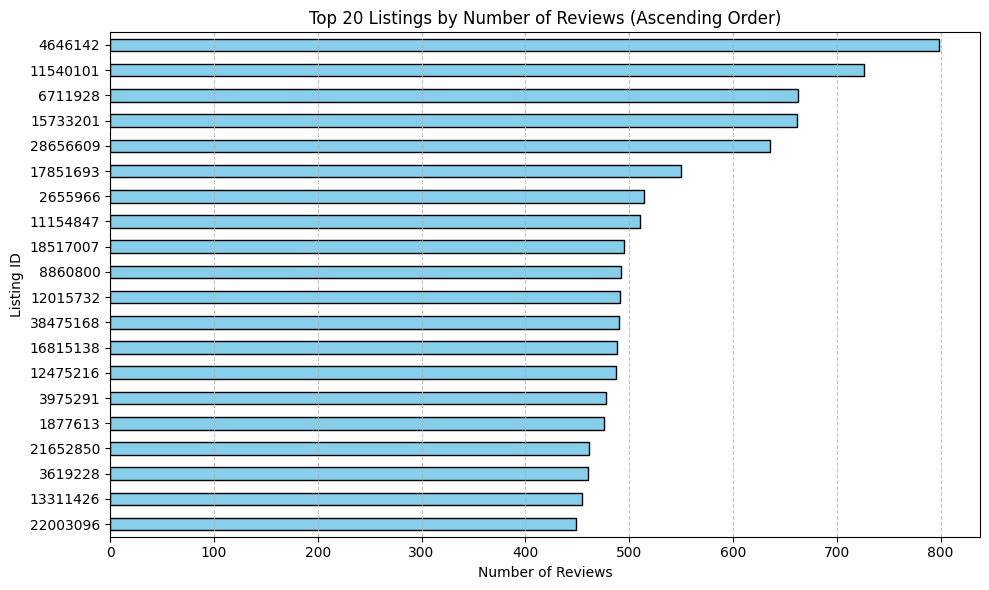

In [7]:
# Get the top 20 listings by review count
top_20_listings = df['listing_id'].value_counts().head(20).sort_values(ascending=True)

# Plot the data
plt.figure(figsize=(10, 6))
top_20_listings.plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Listing ID')
plt.title('Top 20 Listings by Number of Reviews (Ascending Order)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Distribution of reviews over time.

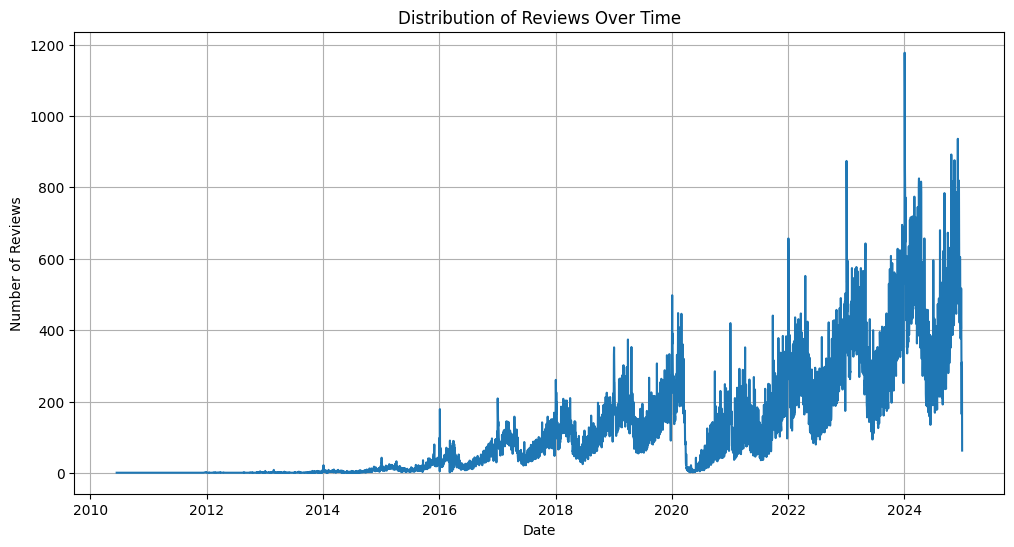

In [8]:
# Convert the 'date' column to datetime objects if it's not already
df['date'] = pd.to_datetime(df['date'])

# Group reviews by date and count them
review_counts = df.groupby('date')['listing_id'].count()

# Create a line plot of review counts over time
plt.figure(figsize=(12, 6))
plt.plot(review_counts.index, review_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews Over Time')
plt.grid(True)
plt.show()

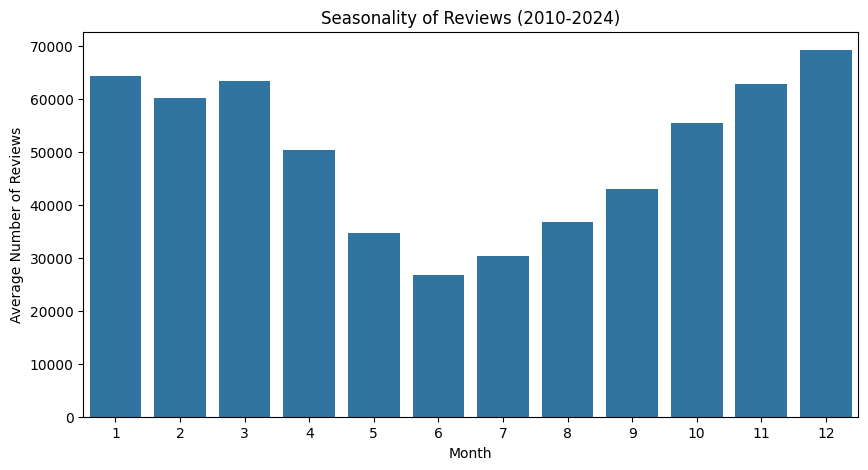

In [11]:
# Analyze for seasonality (example using monthly averages)
df['month'] = df['date'].dt.month
monthly_reviews = df.groupby('month')['listing_id'].count()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_reviews.index, y=monthly_reviews.values)
plt.xlabel('Month')
plt.ylabel('Average Number of Reviews')
plt.title('Seasonality of Reviews (2010-2024)')
plt.show()

Analyze the length of comments

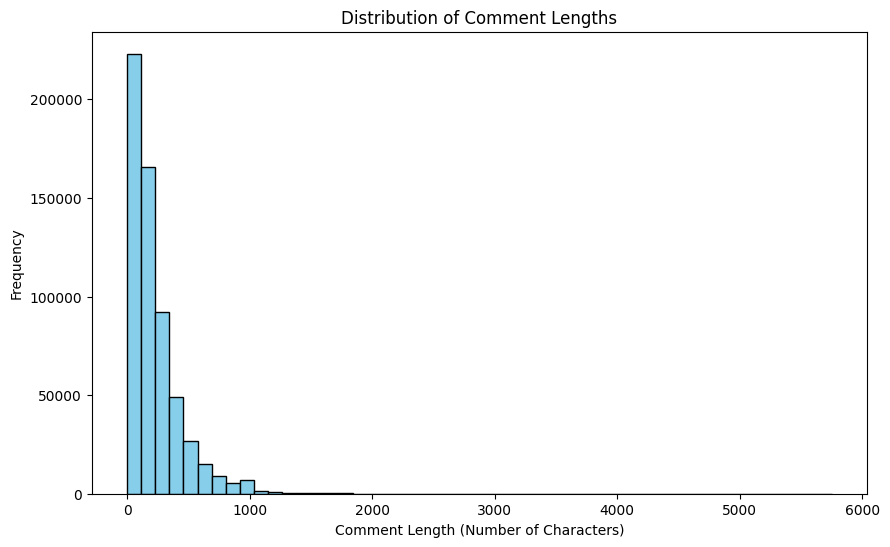

In [37]:
# Calculate the lengths of the comments
comment_lengths = df['comments'].str.len()

# Plot a histogram of comment lengths
plt.figure(figsize=(10, 6))
plt.hist(comment_lengths, bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

# Preprocessing a Random Listing with Sufficient Reviews for Analysis

In [16]:
import random

# Minimum number of reviews required
min_reviews = 20  # Adjust as needed

# Select a random listing_id
while True:
    random_listing_id = random.choice(df['listing_id'].unique())
    filtered_reviews = df[df['listing_id'] == random_listing_id]

    # Check if the listing has enough reviews
    if len(filtered_reviews) >= min_reviews:
        break  # Exit the loop if enough reviews are found

print(f"Selected listing_id: {random_listing_id}")
print(filtered_reviews['listing_id'].value_counts())

Selected listing_id: 24596450
listing_id
24596450    51
Name: count, dtype: int64


## 1. Language Detection and Filtering Non-English Reviews

Detect and Remove Non-English Reviews

In [18]:
pip install langdetect


     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---------------------------------------- 0.0/981.5 kB ? eta -:--:--
     ---------- ----------------------------- 262.1/981.5 kB ? eta -:--:--
     ------------------------------ ------- 786.4/981.5 kB 1.9 MB/s eta 0:00:01
     -------------------------------------- 981.5/981.5 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993363 sha256=0a5c18effb422b9a3ff813a3cc5552f7722674814c65ea8ecc6e3e9db38197b5
  Stored in directory: c:\users\nkosa\appdata\local\pip\


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Set seed for reproducibility in language detection: Ensuring Consistent Results
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        # If language detection fails, assume it's not English
        return 'unknown'

Apply Language Detection

In [21]:
# Apply Language Detection
filtered_reviews.loc[:, 'language'] = filtered_reviews['comments'].apply(detect_language)

# Display the language distribution
print(filtered_reviews['language'].value_counts())

# Filter Out Non-English Reviews
df_english = filtered_reviews[filtered_reviews['language'] == 'en']

# Reset index after filtering
df_english.reset_index(drop=True, inplace=True)

# Check the shape of the filtered dataset
print("Original dataset size:", filtered_reviews.shape)
print("Filtered dataset size:", df_english.shape)

language
en    46
de     3
nl     2
Name: count, dtype: int64
Original dataset size: (51, 8)
Filtered dataset size: (46, 8)


## 2. Clean Reviews

Clean review text by removing unnecessary characters, HTML tags, URLs, and special symbols.

In [23]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  #Remove HTML tags as they might confuse the model
    text = re.sub(r'http\S+|www.\S+', '', text)   # Remove URLs
    return text

df_english.loc[:, 'cleaned_comments'] = df_english['comments'].apply(clean_text)

# RoBERTa Model

In [24]:
# Import neccessary libraries

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [25]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [26]:
example = df_english['cleaned_comments'].iloc[2]
print(example)

Thank you Sharon and Denis for the wonderful holiday accommodation.  This is truly a special place.  Stunning views and everything you need accommodation.  Sharon is most helpful and loved our daily visits from the dogs.  Felt right at home.


In [27]:
encoded_text = tokenizer(example, return_tensors='pt', truncation=True, padding=True, max_length=512)
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.0015233379), 'roberta_neu': np.float32(0.007886899), 'roberta_pos': np.float32(0.99058974)}


In [28]:
from tqdm import tqdm

def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt', truncation=True, padding=True, max_length=512)
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [29]:
results = {}
for i, row in tqdm(df_english.iterrows(), total=len(df_english)):
  try:
    text = row['cleaned_comments']
    myid = row['id']

    # RoBERTa Sentiment Analysis
    roberta_result = polarity_scores_roberta(text)

    # Storing Results
    results[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

100%|██████████| 46/46 [00:10<00:00,  4.51it/s]


In [30]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = filtered_reviews.merge(results_df, how='left')

In [31]:
results_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,month,language,roberta_neg,roberta_neu,roberta_pos
0,24596450,357389261,2018-12-10,130383028,Diane,What a special and wonderful find !!! Absolute...,12,en,0.001480,0.006063,0.992457
1,24596450,360091120,2018-12-19,225253303,Pat,Great hosts loved the place lived the dogs gre...,12,en,0.002686,0.018950,0.978364
2,24596450,367555709,2019-01-05,166399744,Susan,Thank you Sharon and Denis for the wonderful h...,1,en,0.001523,0.007887,0.990590
3,24596450,534892321,2019-09-23,124531615,Tim,Sharon is a fantastic host really informative ...,9,en,0.003201,0.018394,0.978406
4,24596450,553059913,2019-10-23,5475422,Hannah,An absolutely fantastic experience staying at ...,10,en,0.001024,0.007409,0.991567


# Results

## 1. Visualize guest satisfaction trends

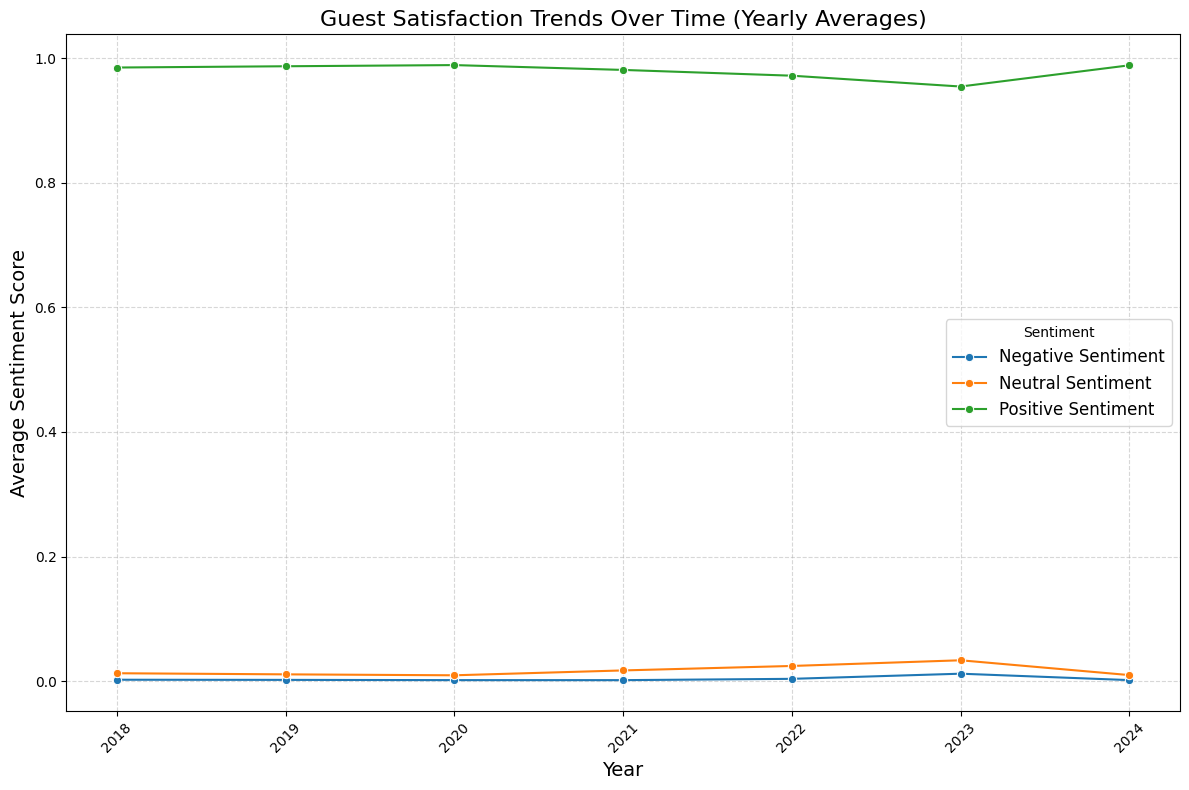

In [32]:
# Group by year and calculate the mean sentiment scores
yearly_sentiment = results_df.groupby(results_df['date'].dt.year)[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Yearly Averages)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(yearly_sentiment.index, rotation=45)  # Show all years on x-axis and rotate for readability
plt.legend(title='Sentiment', fontsize=12) # Add legend title
plt.grid(True, linestyle='--', alpha=0.5) # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Quaterly Averagas

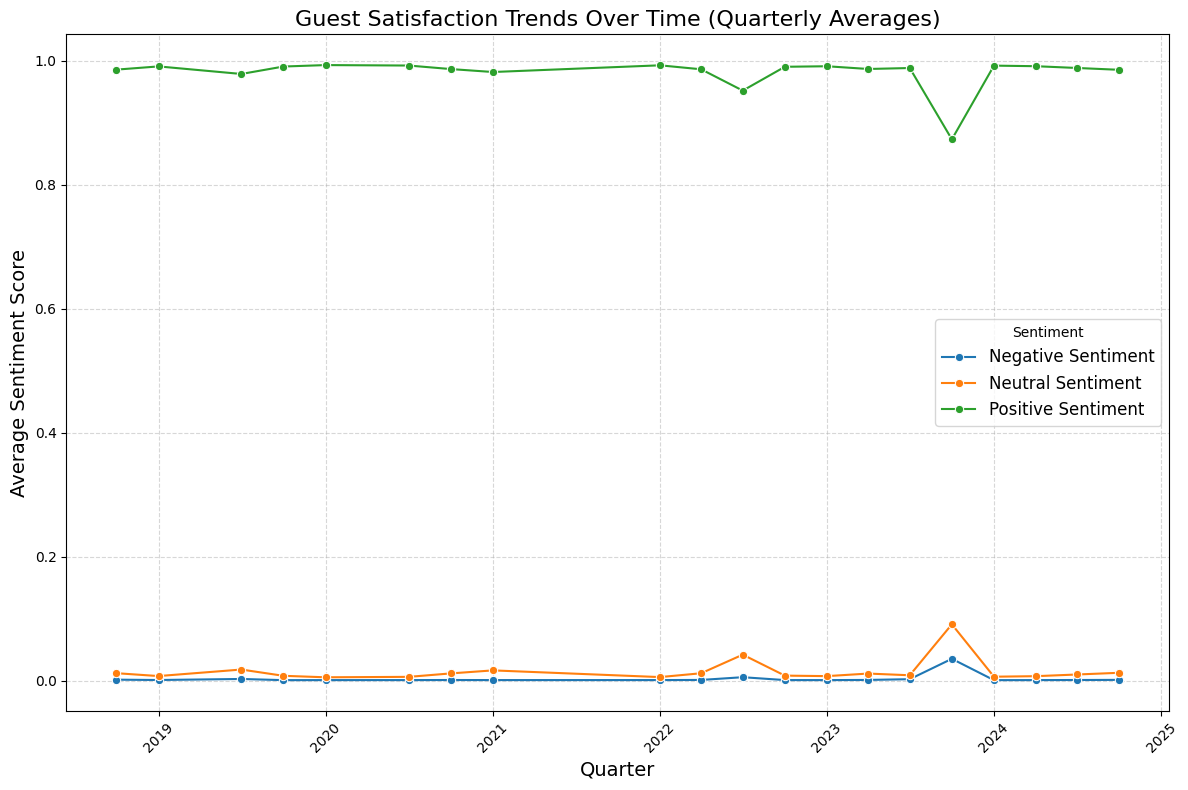

In [33]:
# Group by quarter and calculate the mean sentiment scores
quarterly_sentiment = results_df.groupby(results_df['date'].dt.to_period('Q'))[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=quarterly_sentiment.index.to_timestamp(), y=quarterly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=quarterly_sentiment.index.to_timestamp(), y=quarterly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=quarterly_sentiment.index.to_timestamp(), y=quarterly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Quarterly Averages)', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Monthly Averages

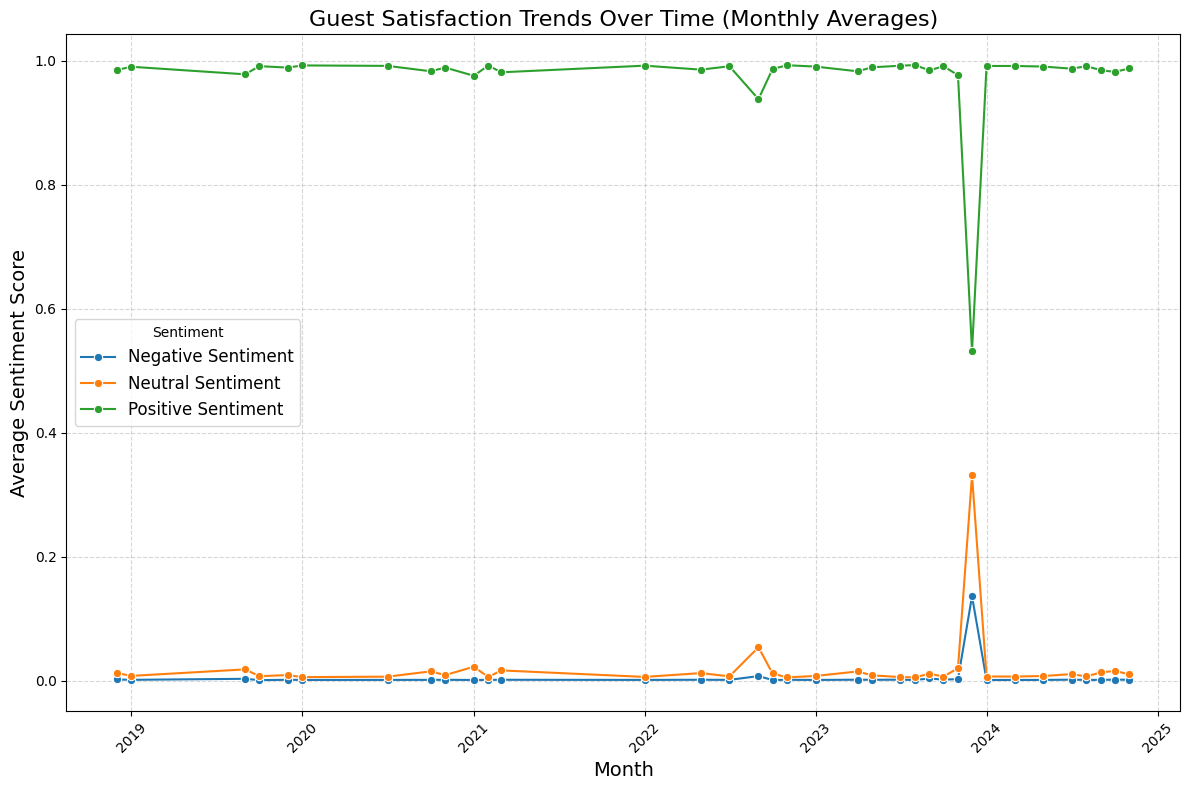

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by month and calculate the mean sentiment scores
monthly_sentiment = results_df.groupby(results_df['date'].dt.to_period('M'))[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=monthly_sentiment.index.to_timestamp(), y=monthly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=monthly_sentiment.index.to_timestamp(), y=monthly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=monthly_sentiment.index.to_timestamp(), y=monthly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Monthly Averages)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()